In [1]:
import numpy as np
from skimage.transform import resize
from skimage import color
import matplotlib.pyplot as plt
import IPython
from neutorch.dataset.border_mask import create_border_mask

%load_ext autoreload
%autoreload 2
%matplotlib inline

def scale_data(vol, seg, size=180):
    length = vol.shape[0]
    vol = resize(vol, (length, size, size))
    seg = resize(seg, (length, size, size), order=0, preserve_range=True, anti_aliasing=False)

    return (vol, seg)
    
def label_data(vol, seg):
    length = vol.shape[0]
    size = vol.shape[1]
    # reshape for labeling
    seg = np.reshape(seg, (size, length*size) )
    vol = np.reshape(vol, (size, length*size) )
    # label
    labeled = color.label2rgb(seg, vol, alpha=0.1, bg_label=-1)
    # shape back
    labeled = np.reshape(labeled, (length, size, size, 3) )

    return labeled

def vis_volume(volume, fig_size=6.5):
    length = volume.shape[0]
    
    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], cmap='gray', interpolation='none', filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()

def view_patch(patch,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(16, 10)
    axarr[0,0].imshow(patch.image[0][i], cmap='gray')
    axarr[0,1].imshow(patch.label[0][i], cmap='prism')
    axarr[0,2].imshow(label_data(patch.image[0],patch.label[0])[i])
    axarr[1,0].imshow(patch.affinity[0][i])
    axarr[1,1].imshow(patch.affinity[1][i])
    axarr[1,2].imshow(patch.affinity[2][i])
    axarr[2,0].imshow(patch.get_lsd_channel(0)[i,:,:,0])
    axarr[2,1].imshow(patch.get_lsd_channel(1)[i,:,:,0])
    axarr[2,2].imshow(patch.get_lsd_channel(2)[i,:,:,0])
    axarr[2,3].imshow(patch.get_lsd_channel(3)[i], cmap='gray')
    plt.show()

def view_affinity(affinity, i=0, fig_size=2):
    plt.rcParams['image.interpolation'] = 'nearest'
    num_aff = affinity.shape[0]
    fig, axarr = plt.subplots(1,num_aff)
    fig.set_size_inches(fig_size*num_aff, fig_size)
    for a in range(num_aff):
        axarr[a].imshow(affinity[a][i], cmap='gray')
        axarr[a].imshow(affinity[a][i], cmap='gray')
        axarr[a].imshow(affinity[a][i], cmap='gray')
    plt.show()

def view_segmentation(seg,i=0, fig_size=10, border=0):
    if border > 0:
        masked_label = np.zeros(seg.shape, dtype=np.uint64)
        create_border_mask(seg, masked_label, border, 0)
        seg = masked_label

    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    colored = color.label2rgb(seg[i], alpha=1, bg_label=0)
    plt.imshow(colored)
    plt.show()

In [2]:
import h5py

def descend_obj(obj,sep='\t'):
    """
    Iterate through groups in a HDF5 file and prints the groups and datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group,h5py._hl.files.File]:
        for key in obj.keys():
            print(sep,'-',key,':',obj[key])
            descend_obj(obj[key],sep=sep+'\t')
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print(sep+'\t','-',key,':',obj.attrs[key])

def h5dump(path,group='/'):
    """
    print HDF5 file metadata

    group: you can give a specific group, defaults to the root group
    """
    with h5py.File(path,'r') as f:
         descend_obj(f[group])


In [10]:
from neutorch.dataset.affinity import Dataset

of = [(1, 1, 1), (2, 3, 3),  (3, 9, 9), (4, 27, 27)]
                
dataset =  Dataset('../../data', patch_size=(26,256,256), length=1000, affinity_offsets=of,
                      lsd=False,  border_width=2)




(34, 310, 310)
loading file sample_A...
loading file sample_B...
loading file sample_C...


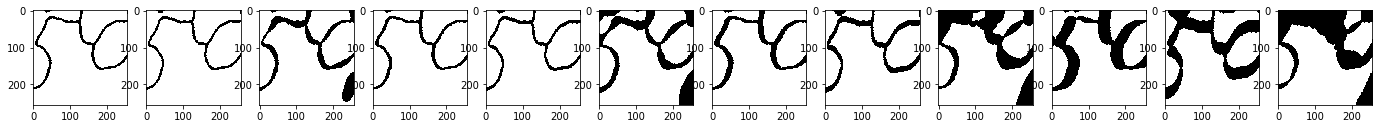

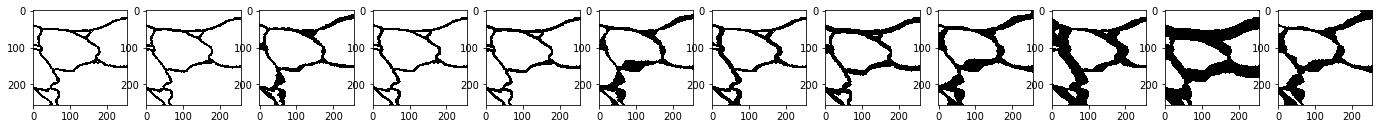

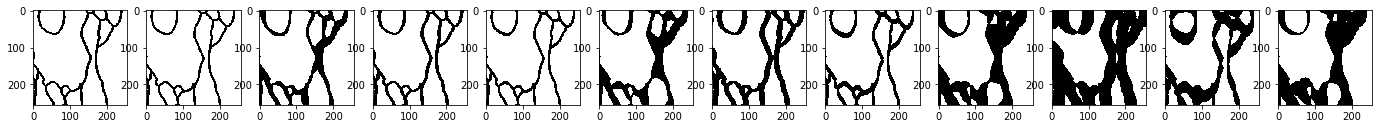

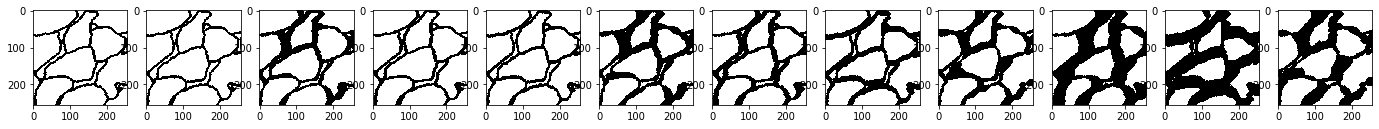

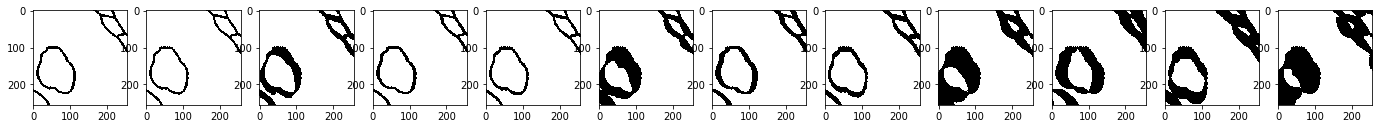

In [18]:
for i in range(5):
    img,lbl = dataset[i]
    view_affinity(lbl)

In [34]:
import numpy as np
affinityA = np.load('../../swin_run/affinity_700000_sample_A_pad.npy')
affinityB = np.load('../../swin_run/affinity_700000_sample_B_pad.npy')
affinityC = np.load('../../swin_run/affinity_700000_sample_C_pad.npy')

segA = np.load('../../swin_run/segmentation_700000_sample_A_pad.npy')
segB = np.load('../../swin_run/segmentation_700000_sample_B_pad.npy')
segC = np.load('../../swin_run/segmentation_700000_sample_C_pad.npy')



In [3]:
from neutorch.dataset.utils import from_h5

trueA = from_h5(f'../../data/sample_A.hdf', dataset_path='volumes/labels/neuron_ids')
trueB = from_h5(f'../../data/sample_B.hdf', dataset_path='volumes/labels/neuron_ids')
trueC = from_h5(f'../../data/sample_C.hdf', dataset_path='volumes/labels/neuron_ids')

In [30]:
view_affinity(affinityC, i=0, fig_size=20)
view_affinity(affinityC, i=1, fig_size=20)
view_affinity(affinityC, i=2, fig_size=20)

NameError: name 'affinityC' is not defined

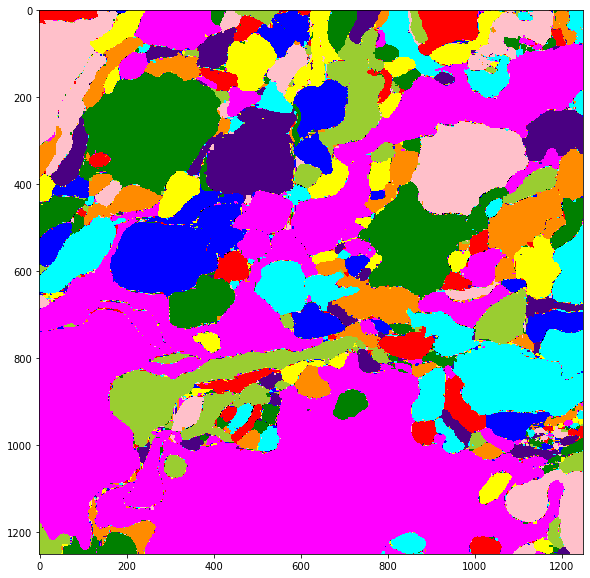

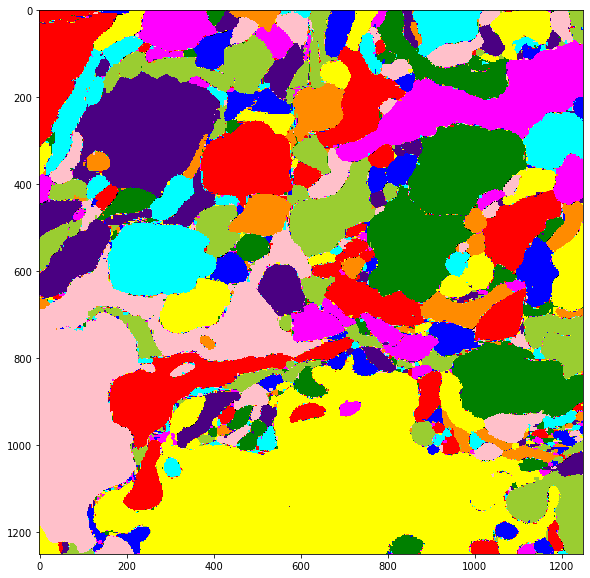

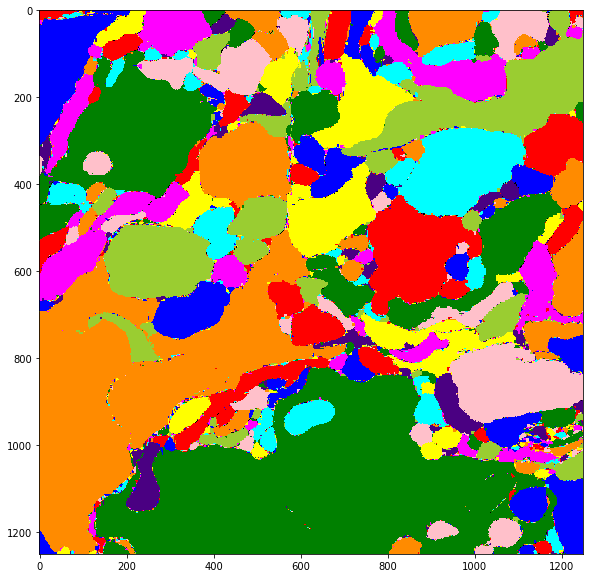

In [14]:
view_segmentation(segC, i=0)
view_segmentation(segC, i=1)
view_segmentation(segC, i=2)


In [4]:
from neutorch.cremi.evaluate import do_agglomeration, cremi_metrics
import numpy as np
import random 

def select_random(vol, sz):
    (z,y,x) = vol.shape[-3:]
    (sz, sy, sx) = sz
    cz = random.randint(0, z-sz)
    cy = random.randint(0, y-sy)
    cx = random.randint(0, x-sx)
    return np.s_[..., cz:cz+sz, cy:cy+sy, cx:cx+sx]

# sl = select_random(affinityC, (30,300,300))
# aff = affinityC[sl]
# tru = trueC[sl]
# seg = do_agglomeration(aff, threshold=0.7)

# seg_clean = seg.copy()
# classes, counts = np.unique(seg, return_counts=True)
# for i, c in enumerate(counts):
#     if c > self.min_volume:
#         self.classes.append(classes[i])
#     if c > self.max_volume:
#         print(c)



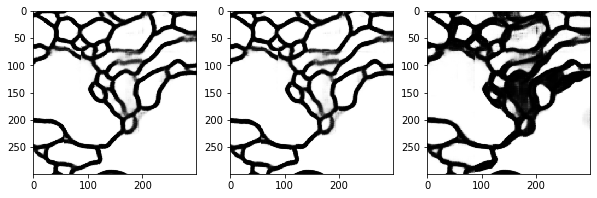

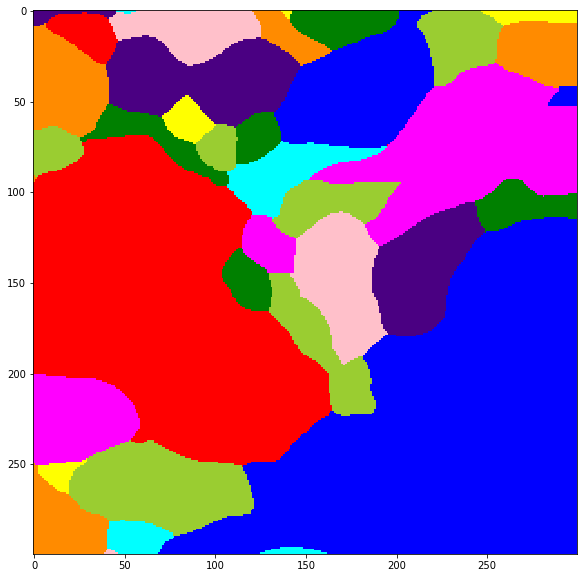

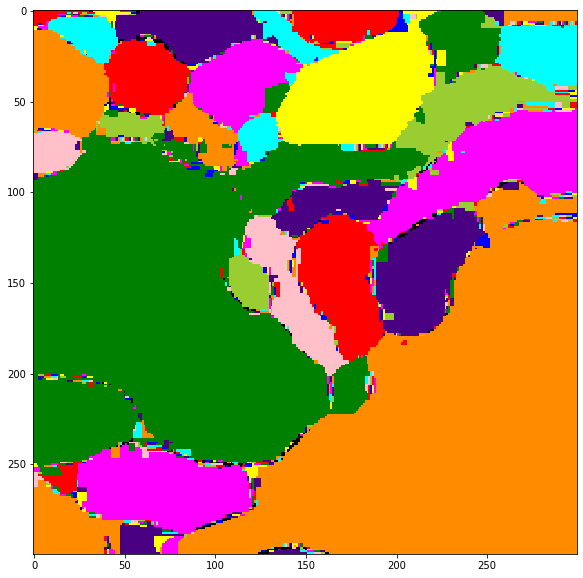

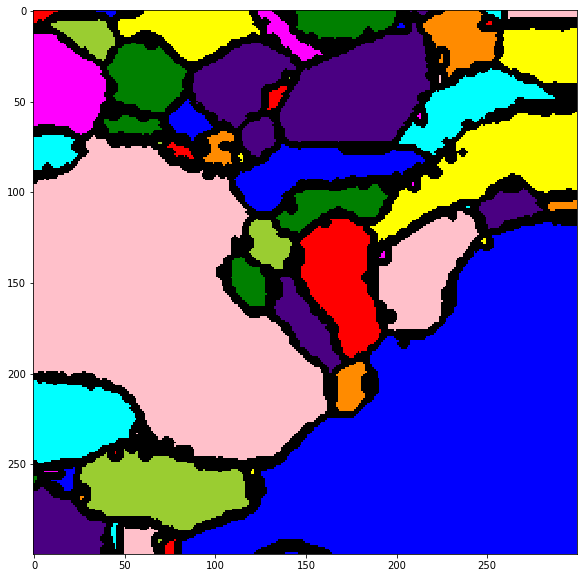

In [87]:
import cc3d
from neutorch.dataset.border_mask import create_border_mask
border_width = 1
# add background mask
masked_label = np.zeros(seg.shape, dtype=np.uint64)
create_border_mask(seg, masked_label, border_width, 0)
seg_conn = cc3d.connected_components(masked_label) 


view_affinity(aff)
view_segmentation(tru)
view_segmentation(seg)
view_segmentation(seg_conn)



In [14]:
from neutorch.dataset.utils import from_h5

trueC = from_h5(f'../../RSUnet2_900000/aff_sample_A_pad.h5', dataset_path='affinity')

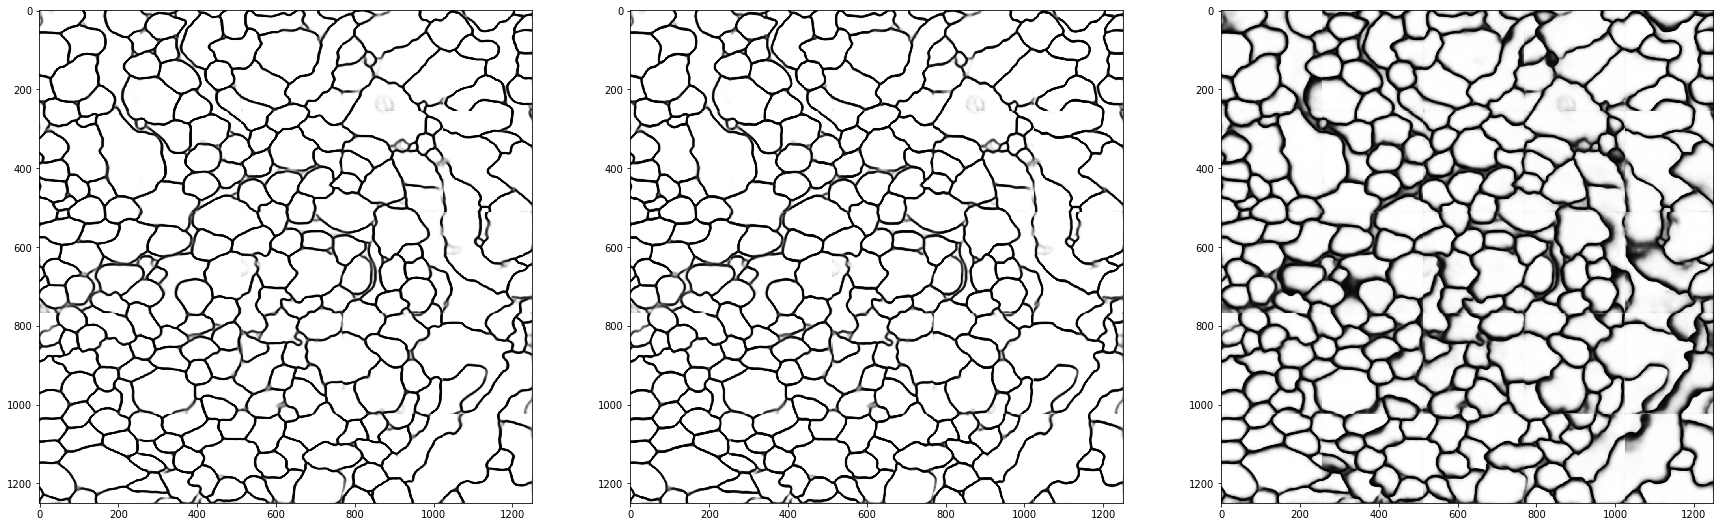

In [9]:
view_affinity(trueC, i=0,fig_size=10)


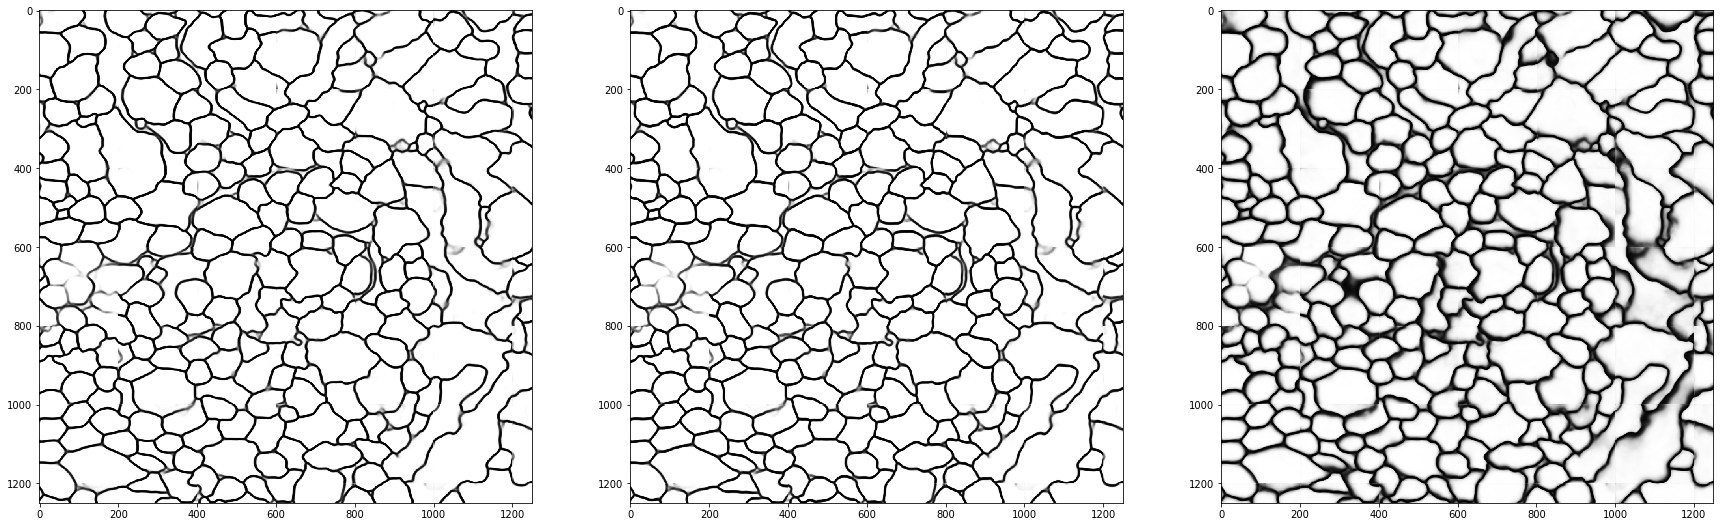

In [18]:
view_affinity(trueC, i=0,fig_size=10)

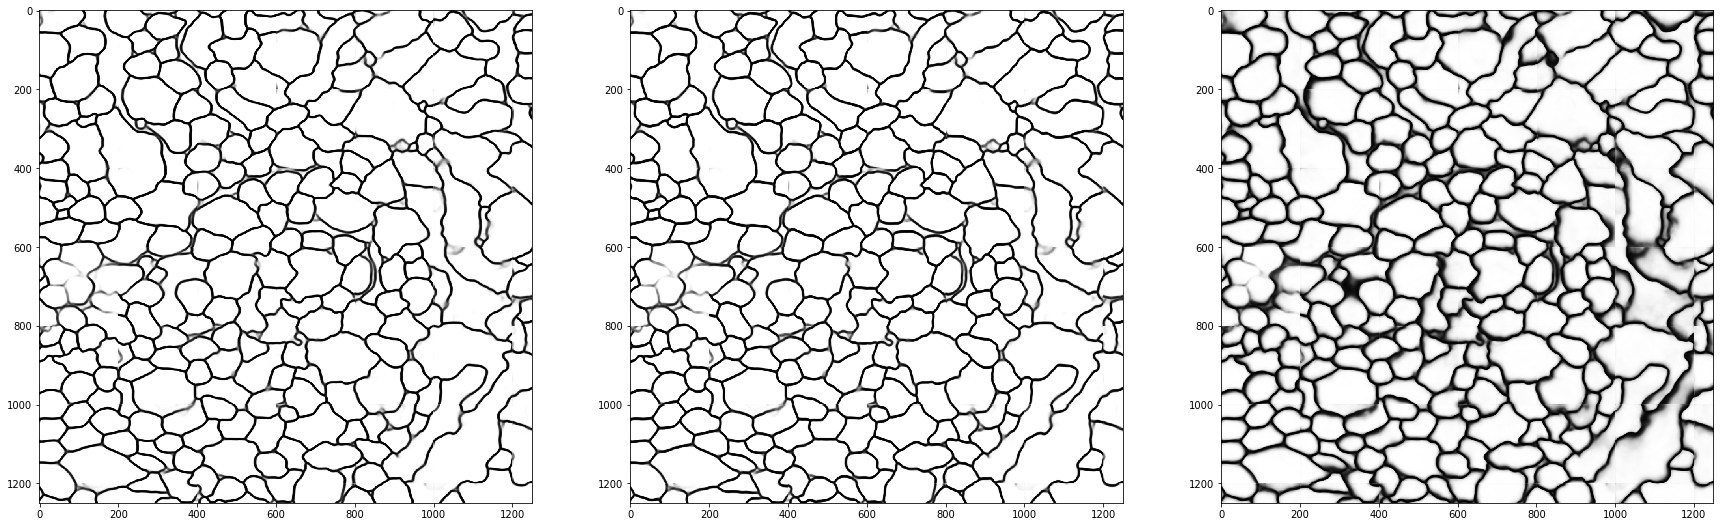

In [19]:
view_affinity(trueC, i=0,fig_size=10)